# **Breast Density Classification - Deep Learning**
**Project  Title:** Breast Density Classification Model

**Course:** Machine Learning for the Life Sciences (BSCI238I) – Fall 2025

**Author:** Catherine Smith

### **Background**

This project develops a **deep learning model** that predicts **breast density** from mammogram images using a **ResNet-50 convolutional neural network**.

The model demonstrates:

* Image preprocessing and dataset management  
* Stratified train/validation/test split  
* Transfer learning with ResNet-50  
* Model training and hyperparameter tuning  
* Evaluation using accuracy, normalized confusion matrices, and Grad-CAM saliency maps  
* Interpretation for early breast cancer risk assessment  

### **References**

1.   [Kaggle -- RSNA Mammography Dataset](https://www.kaggle.com/competitions/rsna-breast-cancer-detection/overview)


## **Prepare Data**


### **Load + inspect dataset**

In [13]:
# import libraries
import zipfile
import os
import pandas as pd

# define file paths
zip_path = "breast_density_data.zip"
images_dir = "mammograms"
csv_output_path = "metadata.csv"

# create output directory
os.makedirs(images_dir, exist_ok=True)

# open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # loop through each file in the zip
    for file_name in zip_ref.namelist():

        if file_name.endswith('.png'):
            # extract image files to the mammograms folder
            zip_ref.extract(file_name, images_dir)

        elif file_name.endswith('.csv'):
            # extract the metadata csv file separately
            zip_ref.extract(file_name, '.')
            os.rename(file_name, csv_output_path)

print("Extraction complete.")
print(f"Images saved in: {images_dir}/")
print(f"CSV file saved as: {csv_output_path}\n")

# view the metadata
print("\nMetadata:")
df = pd.read_csv("metadata.csv")
df

Extraction complete.
Images saved in: mammograms/
CSV file saved as: metadata.csv


Metadata:


site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0          1       30865  1984254218          L   CC  75.0       0       0   
1          1        4063   615507631          R   CC  57.0       0       0   
2          1       12663  1182432939          R   CC  56.0       0       0   
3          1        9795   711528012          R   CC  65.0       0       0   
4          1       16198   849793332          L   CC  70.0       0       0   
..       ...         ...         ...        ...  ...   ...     ...     ...   
795        1       17775   801524001          R   CC  59.0       0       0   
796        1       62020   803147142          L   CC  47.0       0       0   
797        1       23933   496554907          R   CC  56.0       0       0   
798        1       44143  1033667408          R   CC  50.0       0       0   
799        1       38080   999892087          R   CC  50.0       0       0   

     invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0           0     1.0        0       A          49                    False   
1           0     1.0        0       A          49                    False   
2           0     2.0        0       A          49                    False   
3           0     1.0        0       A          49                    False   
4           0     NaN        0       A          49                    False   
..        ...     ...      ...     ...         ...                      ...   
795         0     1.0        0       D         216                    False   
796         0     1.0        0       D         216                    False   
797         0     1.0        0       D          49                    False   
798         0     1.0        0       D          49                    False   
799         0     NaN        0       D         216                    False   

                 filename  
0    30865_1984254218.png  
1      4063_615507631.png  
2    12663_1182432939.png  
3      9795_711528012.png  
4     16198_849793332.png  
..                    ...  
795   17775_801524001.png  
796   62020_803147142.png  
797   23933_496554907.png  
798  44143_1033667408.png  
799   38080_999892087.png  

[800 rows x 15 columns]

In [14]:
# get number of images in each density category
df["density"].value_counts()

density
A    200
B    200
C    200
D    200
Name: count, dtype: int64

### **Split data**

*   70% training data
* 15% validation data
* 15% test data


Training: 560 images, Validation: 120 images, Testing: 120 images




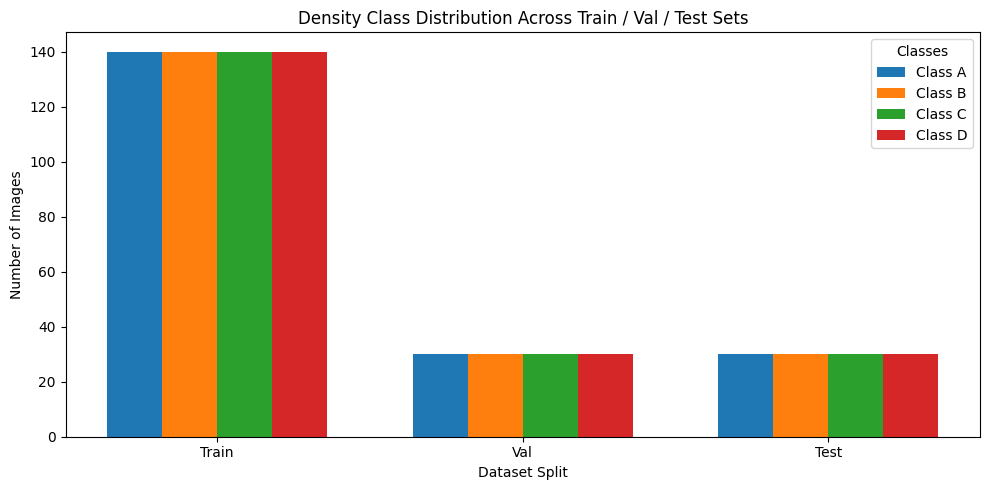

In [15]:
# import libraries
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR

# set random seed so that results are reproducible
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# detect our gpu device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# specify image directory and density classes
IMG_DIR = "mammograms"
classes = ["A", "B", "C", "D"]
class_to_idx = {c:i for i, c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
df = df[df["density"].isin(classes)].copy()
df["label"] = df["density"].map(class_to_idx).astype(int)

# create stratified split: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=seed
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=seed
)
print(f"Training: {len(train_df)} images, Validation: {len(val_df)} images, Testing: {len(test_df)} images\n\n")

# display a bar graph of density class distribution across train/test/val splits
def plot_split_distributions(train_df, val_df, test_df, classes):
    train_counts = train_df["density"].value_counts().reindex(classes).fillna(0).astype(int)
    val_counts   = val_df["density"].value_counts().reindex(classes).fillna(0).astype(int)
    test_counts  = test_df["density"].value_counts().reindex(classes).fillna(0).astype(int)
    splits = ["Train", "Val", "Test"]
    counts = np.array([train_counts.values, val_counts.values, test_counts.values])
    x = np.arange(len(splits))
    n_classes = len(classes)
    width = 0.18
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    for i, c in enumerate(classes):
        ax.bar(x + (i - 1.5)*width, counts[:, i], width, label=f"Class {c}", color=colors[i])
    ax.set_xticks(x)
    ax.set_xticklabels(splits)
    ax.set_xlabel("Dataset Split")
    ax.set_ylabel("Number of Images")
    ax.set_title("Density Class Distribution Across Train / Val / Test Sets")
    ax.legend(title="Classes")
    plt.tight_layout()
    plt.show()

# create the density distribution bar graph
plot_split_distributions(train_df, val_df, test_df, classes)

## **Train Model**

### **Model set-up**

In [16]:
# define a class for handling mammograms
class MammogramDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, row["filename"])
        img = Image.open(path).convert("L")
        if self.transform is not None:
            img = self.transform(img)
        label = int(row["label"])
        return img, label, row["filename"]

# specify transforms to apply to images during training
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # turn images to grayscale
    transforms.Resize((400,400)), # resize images to be 400x400 pixels
    transforms.RandomHorizontalFlip(p=0.5), # randomly flip each image L/R
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # normalize images to ResNet's mean and std
                         std=[0.229, 0.224, 0.225]),
])
eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((400,400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# create an object for each train/test/validation set
train_ds = MammogramDataset(train_df, IMG_DIR, transform=train_tf)
val_ds   = MammogramDataset(val_df,   IMG_DIR, transform=eval_tf)
test_ds  = MammogramDataset(test_df,  IMG_DIR, transform=eval_tf)

# set hyperparameters related to compute power and resources available
batch_size = 8    # number of images seen and processed by the model at one time
num_workers = 4  # number of simultaneous image loading processes running at a time

# create objects for loading images into the model
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### **Hyperparameter tuning**

In [17]:
# get the model weights for the pretrained ResNet-50 that will serve as our baseline
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# specify the number of epochs we will train for
num_epochs = 15

# specify the loss function to use during training
# cross entropy loss is most commonly used for classification tasks
criterion = nn.CrossEntropyLoss()

# lr parameter sets the initial learning rate
# weight_decay parameter applies weight decay to improve generalizability
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, weight_decay = 3e-3)

# apply a cosine function for learning rate decay
# eta_min parameter sets the lowest learning rate that we will decay to
scheduler = CosineAnnealingLR(optimizer, T_max = num_epochs, eta_min = 1e-7)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


### **Training loop**

In [18]:
# function defining what happens during each epoch
def run_epoch(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    # initialize loss and accuracy for this epoch
    total_loss = 0.0
    total_correct = 0
    total = 0

    # iteratively load images, perform gradient descent, compute loss, update weights
    for imgs, labels, _ in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if is_train:
            optimizer.zero_grad() # reset gradient buffers to 0
        outputs = model(imgs)  # forward propagation!
        loss = criterion(outputs, labels) # compute loss
        if is_train:
            loss.backward()   # backpropagation (and compute gradients)!
            optimizer.step()  # update parameters!
        total_loss += loss.item() * imgs.size(0)  # increment the loss
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item() # calculate accuracy
        total += imgs.size(0)

    # save average loss and accuracy for this epoch
    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

# dictionary to keep track of loss metrics across epochs
history = {"train_loss": [], "val_loss": [], "val_acc": [], "lr": []}
best_val_acc = 0.0
best_state = None

# main training loop
for epoch in range(1, num_epochs+1):

    # one training epoch (updates weights for the model)
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)

    # one validation epoch (using the current model)
    val_loss, val_acc = run_epoch(val_loader, model, criterion, optimizer=None)

    # record loss metrics
    current_lr = optimizer.param_groups[0]['lr']
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    # display loss metrics to the screen
    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc*100:.2f}% | "
          f"LR: {current_lr:.6f}")
    scheduler.step()

    # saves a copy of the best-performing model so far (based on validation accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# reload best model weights after training (final model)
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

Epoch 01/15 | Train Loss: 1.3703 | Val Loss: 1.3546 | Val Acc: 45.83% | LR: 0.000010
Epoch 02/15 | Train Loss: 1.3087 | Val Loss: 1.2576 | Val Acc: 45.00% | LR: 0.000010
Epoch 03/15 | Train Loss: 1.1840 | Val Loss: 1.1099 | Val Acc: 61.67% | LR: 0.000010
Epoch 04/15 | Train Loss: 1.0679 | Val Loss: 1.0026 | Val Acc: 60.83% | LR: 0.000009
Epoch 05/15 | Train Loss: 0.9639 | Val Loss: 0.9296 | Val Acc: 66.67% | LR: 0.000008
Epoch 06/15 | Train Loss: 0.8790 | Val Loss: 0.8951 | Val Acc: 60.83% | LR: 0.000008
Epoch 07/15 | Train Loss: 0.8025 | Val Loss: 0.8249 | Val Acc: 70.00% | LR: 0.000007
Epoch 08/15 | Train Loss: 0.7544 | Val Loss: 0.7786 | Val Acc: 72.50% | LR: 0.000006
Epoch 09/15 | Train Loss: 0.7115 | Val Loss: 0.7499 | Val Acc: 74.17% | LR: 0.000005
Epoch 10/15 | Train Loss: 0.6755 | Val Loss: 0.7290 | Val Acc: 71.67% | LR: 0.000004
Epoch 11/15 | Train Loss: 0.6417 | Val Loss: 0.7197 | Val Acc: 72.50% | LR: 0.000003
Epoch 12/15 | Train Loss: 0.6671 | Val Loss: 0.7289 | Val Acc: 74

### **Learning curves**

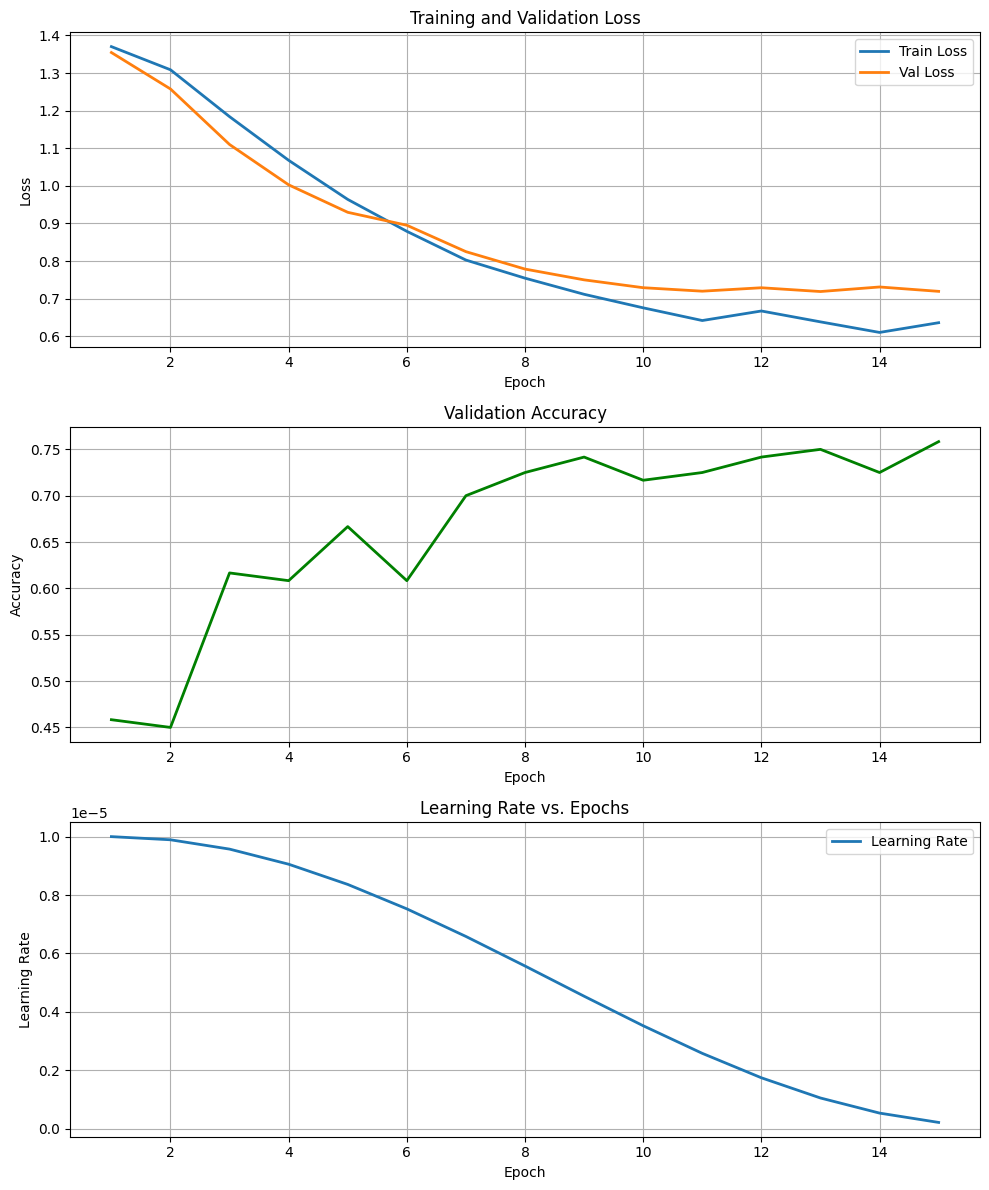

In [20]:
epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10, 12))

# --- Plot 1: Training vs Validation Loss ---
plt.subplot(3, 1, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", linewidth=2)
plt.plot(epochs, history["val_loss"], label="Val Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# --- Plot 2: Validation Accuracy ---
plt.subplot(3, 1, 2)
plt.plot(epochs, history["val_acc"], color="green", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)

# --- Plot 3: Learning Rate over Time ---
plt.subplot(3, 1, 3)
plt.plot(epochs, history["lr"], label="Learning Rate", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs. Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Evaluate Model**

### **Test model**


Overall Accuracy: 80.83%

Class A: Sensitivity = 93.33% | Specificity = 88.89%
Class B: Sensitivity = 56.67% | Specificity = 98.89%
Class C: Sensitivity = 86.67% | Specificity = 90.00%
Class D: Sensitivity = 86.67% | Specificity = 96.67%

Overall Sensitivity: 80.83%
Overall Specificity: 93.61%



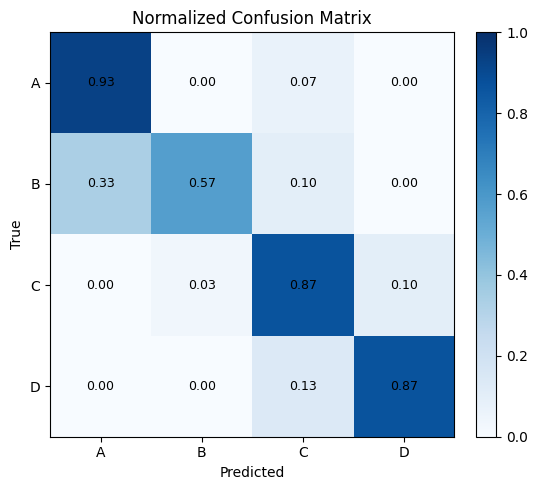

In [21]:
# initialize variables
model.eval()
all_labels = []
all_preds = []

# run the model and generate a prediction for each image in the test set
with torch.no_grad():
    for imgs, labels, _ in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# compute model accuracy on the test set
test_acc = (all_preds == all_labels).mean()

# generate a confusion matrix with results
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(classes))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# calculate sensitivity and specificity for each class
sensitivities = []
specificities = []
for i in range(len(classes)):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    sensitivities.append(sens)
    specificities.append(spec)
macro_sens = np.mean(sensitivities)
macro_spec = np.mean(specificities)

# display accuracy, sensitivity, and specificity
print(f"\nOverall Accuracy: {test_acc*100:.2f}%\n")
for i, c in enumerate(classes):
    print(f"Class {c}: Sensitivity = {sensitivities[i]*100:.2f}% | Specificity = {specificities[i]*100:.2f}%")
print(f"\nOverall Sensitivity: {macro_sens*100:.2f}%")
print(f"Overall Specificity: {macro_spec*100:.2f}%\n")

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(len(classes))); ax.set_xticklabels(classes)
ax.set_yticks(np.arange(len(classes))); ax.set_yticklabels(classes)
plt.title("Normalized Confusion Matrix")
plt.colorbar(im, fraction=0.046, pad=0.04)
for i in range(len(classes)):
    for j in range(len(classes)):
        val = cm_norm[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=9)
plt.tight_layout()
plt.show()

### **Saliency maps**

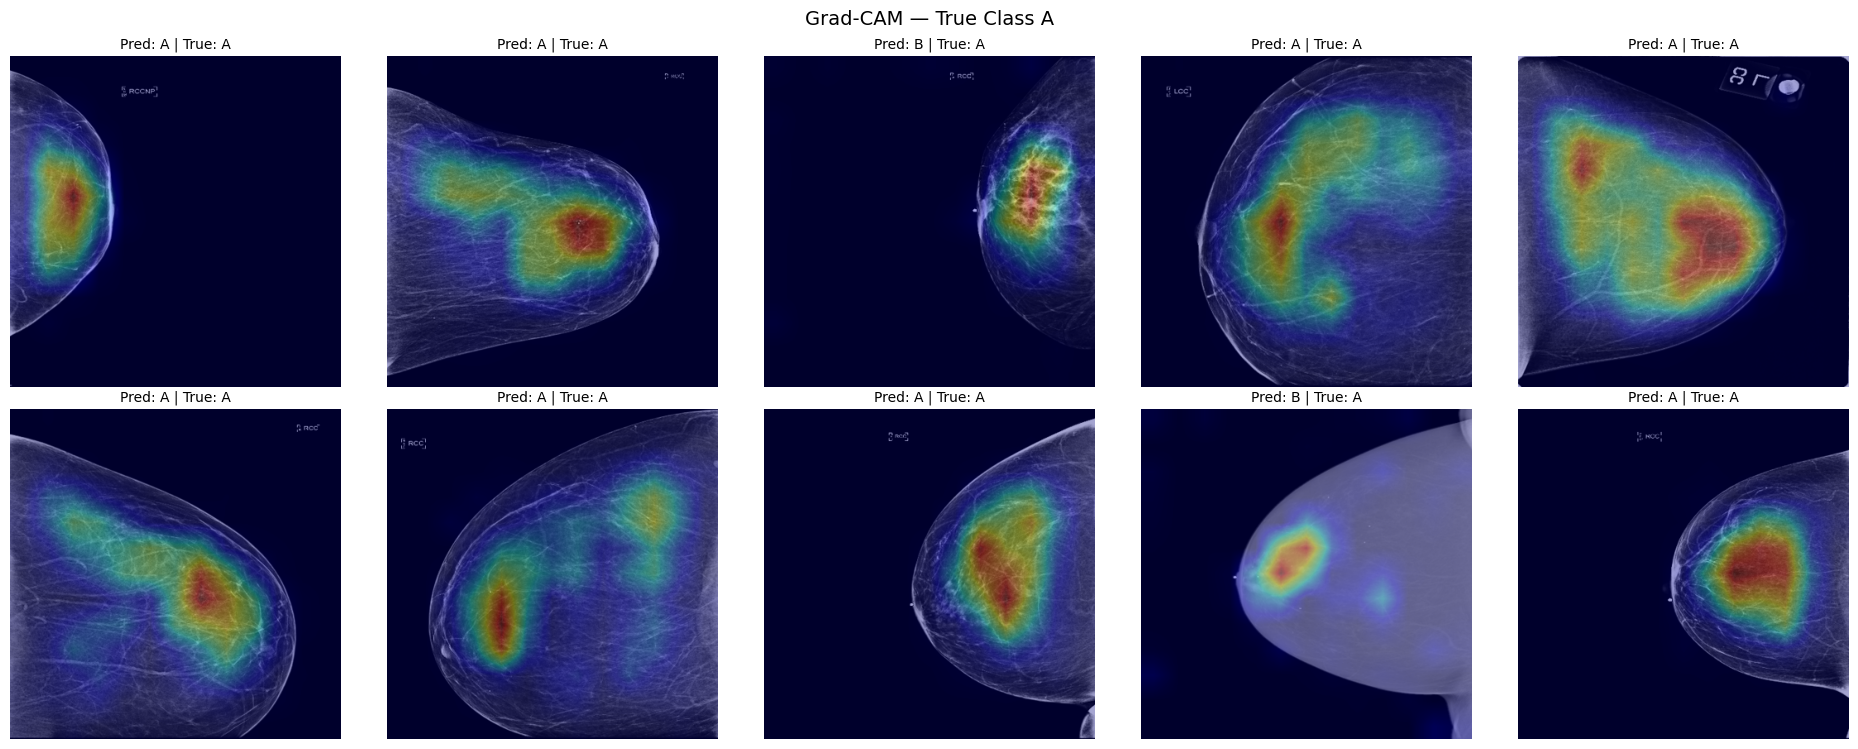

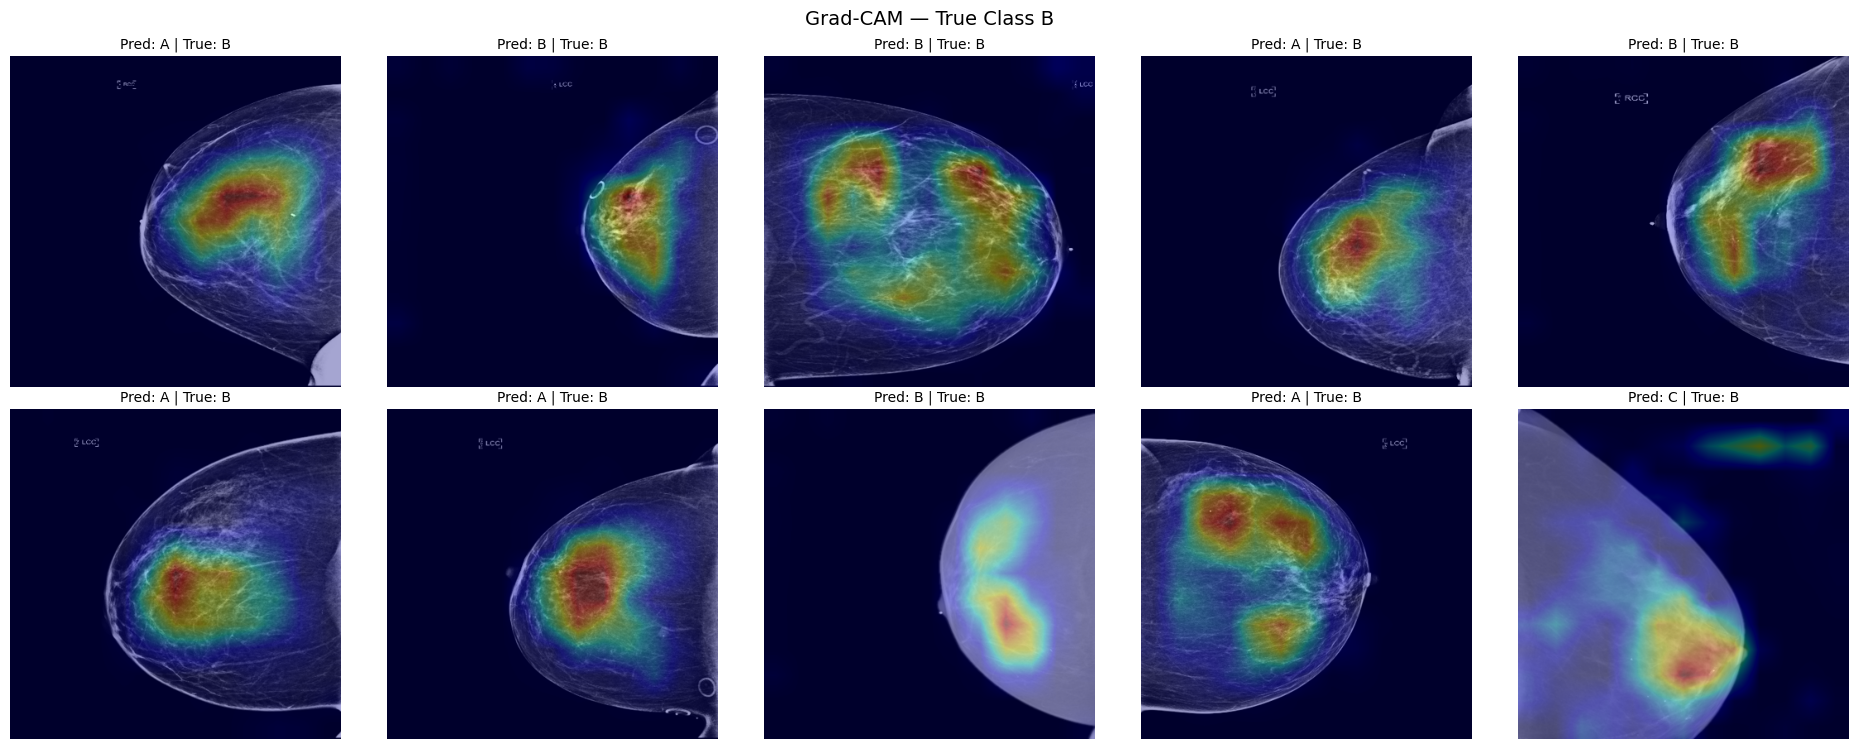

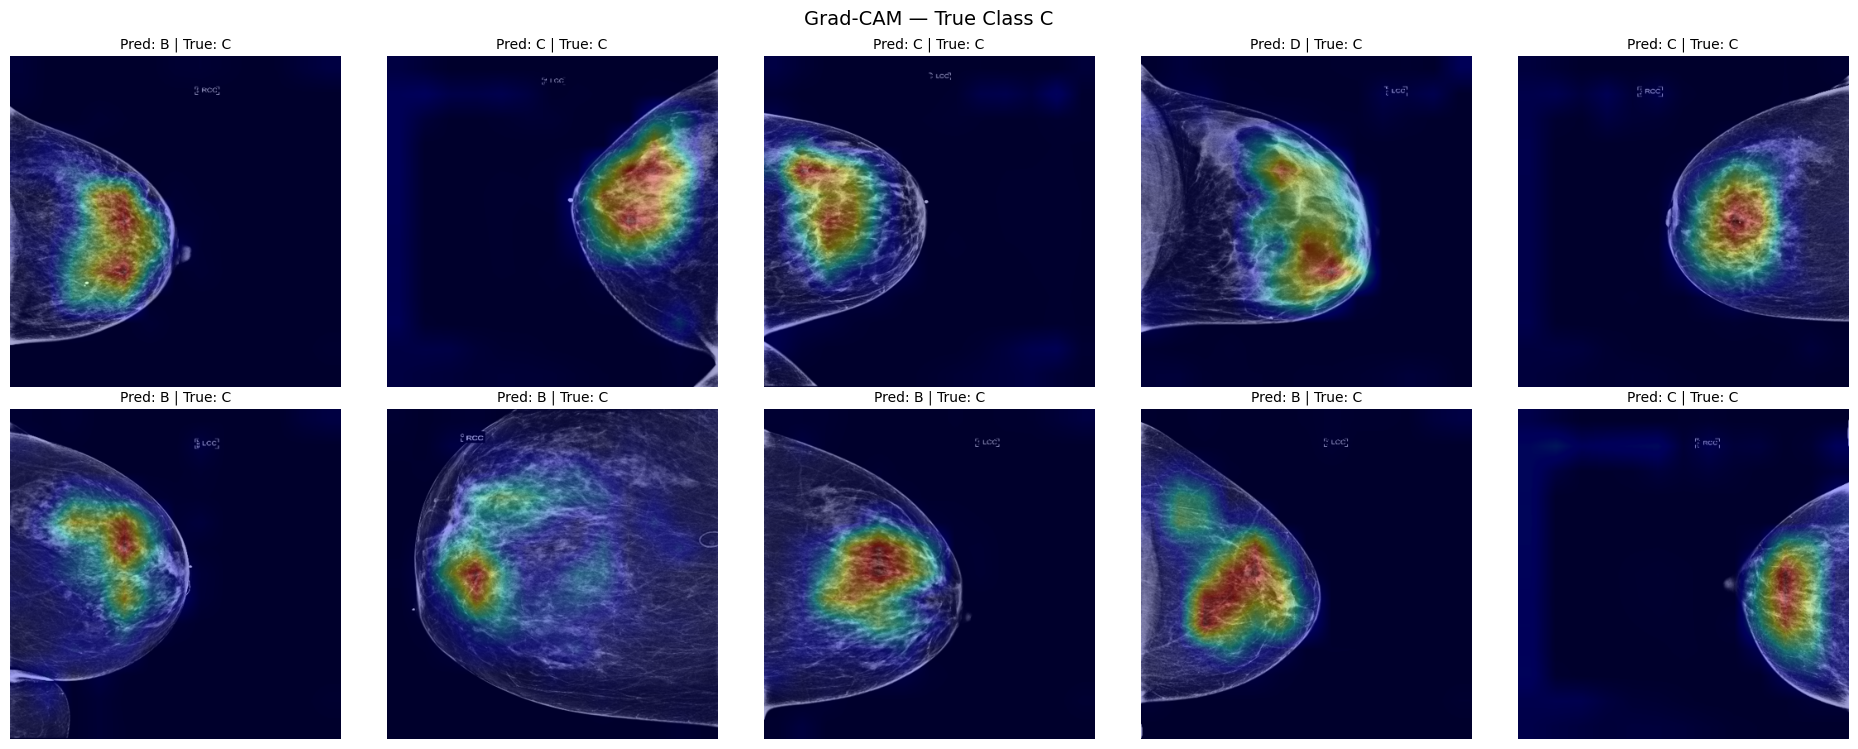

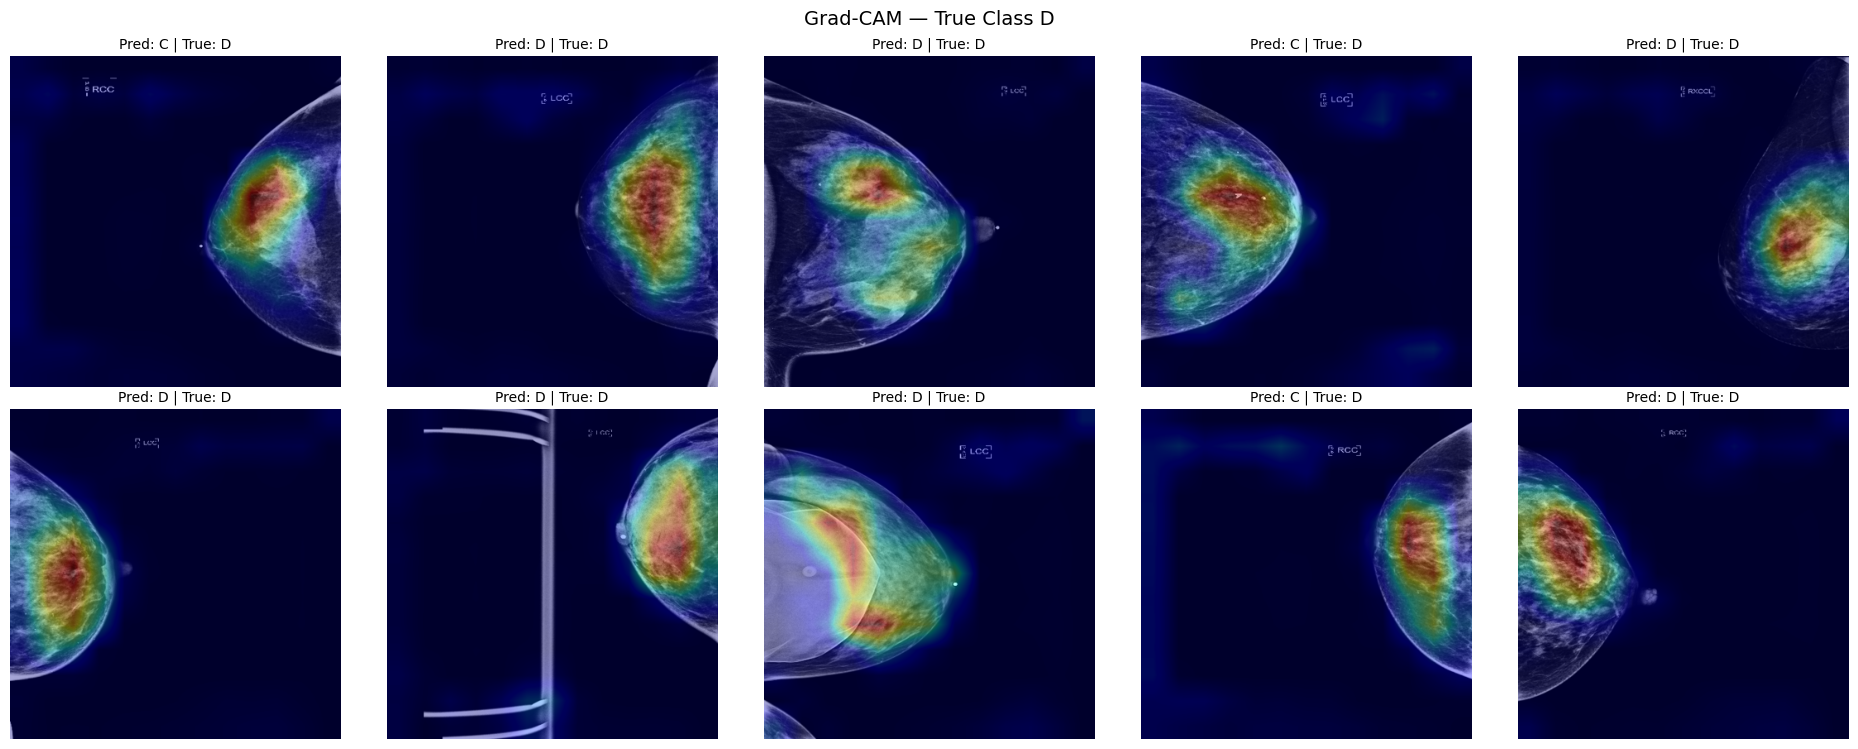

In [22]:
# grad-cam visualization script

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import colormaps
from PIL import Image

gradients = {}
activations = {}

def _save_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach()
    return hook

def _save_gradient(name):
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0].detach()
    return hook

_target_layer = model.layer4
_act_handle = _target_layer.register_forward_hook(_save_activation("feat"))
_grad_handle = _target_layer.register_full_backward_hook(_save_gradient("feat"))

def generate_gradcam(input_tensor, class_idx=None):
    model.eval()
    input_tensor = input_tensor.to(device)
    input_tensor.requires_grad_(True)

    output = model(input_tensor)
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    score = output[0, class_idx]

    model.zero_grad()
    score.backward(retain_graph=True)

    feats = activations["feat"]
    grads = gradients["feat"]

    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * feats).sum(dim=1, keepdim=False)
    cam = F.relu(cam)

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    H, W = input_tensor.shape[2], input_tensor.shape[3]
    cam_up = F.interpolate(cam.unsqueeze(1), size=(H, W), mode="bilinear", align_corners=False)
    cam_up = cam_up.squeeze(1).squeeze(0)

    return cam_up.detach().cpu().numpy()

def overlay_heatmap_on_image(img_np, heatmap, alpha=0.35, cmap_name="jet"):
    if img_np.ndim == 2:
        base = np.stack([img_np]*3, axis=-1)
    else:
        base = img_np
    if base.dtype != np.uint8:
        base = np.clip(base, 0, 255).astype(np.uint8)

    cmap = colormaps.get_cmap(cmap_name)
    hmap_rgb = (cmap(np.clip(heatmap, 0, 1))[..., :3] * 255).astype(np.uint8)

    over = alpha * hmap_rgb.astype(np.float32) + (1 - alpha) * base.astype(np.float32)
    return np.clip(over, 0, 255).astype(np.uint8)

samples_by_class = {c: [] for c in classes}
test_by_class = {c: test_df[test_df["density"] == c] for c in classes}
for c in classes:
    sub = test_by_class[c]
    n = min(10, len(sub))
    if n > 0:
        samples_by_class[c] = sub.sample(n, random_state=42)

def load_disp_and_tensor(path):
    img = Image.open(path).convert("L")
    disp = img.resize((400, 400))
    disp_np = np.array(disp)
    inp = eval_tf(disp)
    return disp_np, inp.unsqueeze(0)

for c in classes:
    subset = samples_by_class[c]
    if len(subset) == 0:
        print(f"No test images for class {c} to visualize.")
        continue

    n = len(subset)
    cols = 5
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3.8*cols, 3.8*rows))
    axes = np.atleast_2d(axes)
    fig.suptitle(f"Grad-CAM — True Class {c}", fontsize=14)

    for i, (_, row) in enumerate(subset.iterrows()):
        r, k = divmod(i, cols)
        ax = axes[r, k]
        path = os.path.join(IMG_DIR, row["filename"])

        disp_img, inp = load_disp_and_tensor(path)

        with torch.no_grad():
            logits = model(inp.to(device))
            pred_idx = logits.argmax(dim=1).item()

        cam = generate_gradcam(inp, class_idx=pred_idx)

        overlay = overlay_heatmap_on_image(disp_img, cam, alpha=0.35, cmap_name="jet")

        ax.imshow(overlay)
        ax.axis("off")
        ax.set_title(f"Pred: {idx_to_class[pred_idx]} | True: {row['density']}", fontsize=10)

    total = rows * cols
    for j in range(n, total):
        r, k = divmod(j, cols)
        axes[r, k].axis("off")

    plt.tight_layout()
    plt.show()

_act_handle.remove()
_grad_handle.remove()
